In [1]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!python -m pip install pyyaml==5.1
!pip install google.colab
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 320.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=aa4b6bb37024f85c620d0e4d52a045c1487ffbcc22cb6354b897079da7bc98cf
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
pytorch-lightning 1.6.4 requires PyYAML>=5.4, but you have pyyaml 5.1 which is incompatible.
kubernetes 23.6.0 requires pyyaml>=5.4.1, but you have pyyaml 5.1 which is incompatible.
dask 2022.2.0 

In [3]:
import pandas as pd
import detectron2
import os
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from detectron2.utils.logger import setup_logger
setup_logger()
import logging

/opt/conda/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
torch:  1.11 ; cuda:  1.11.0
detectron2: 0.6


In [5]:
data_dir = "../input/gtsrb-german-traffic-sign"

train_path = "../input/gtsrb-german-traffic-sign/Train"
test_path = "../input/gtsrb-german-traffic-sign/Test"

train_labels_path = "../input/gtsrb-german-traffic-sign/Train.csv"
test_labels_path = "../input/gtsrb-german-traffic-sign/Test.csv"

stop_sign_id = 14

In [6]:
train_labels = pd.read_csv(train_labels_path)
test_labels = pd.read_csv(test_labels_path)

filtered_labels = train_labels[train_labels['ClassId'] == stop_sign_id]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


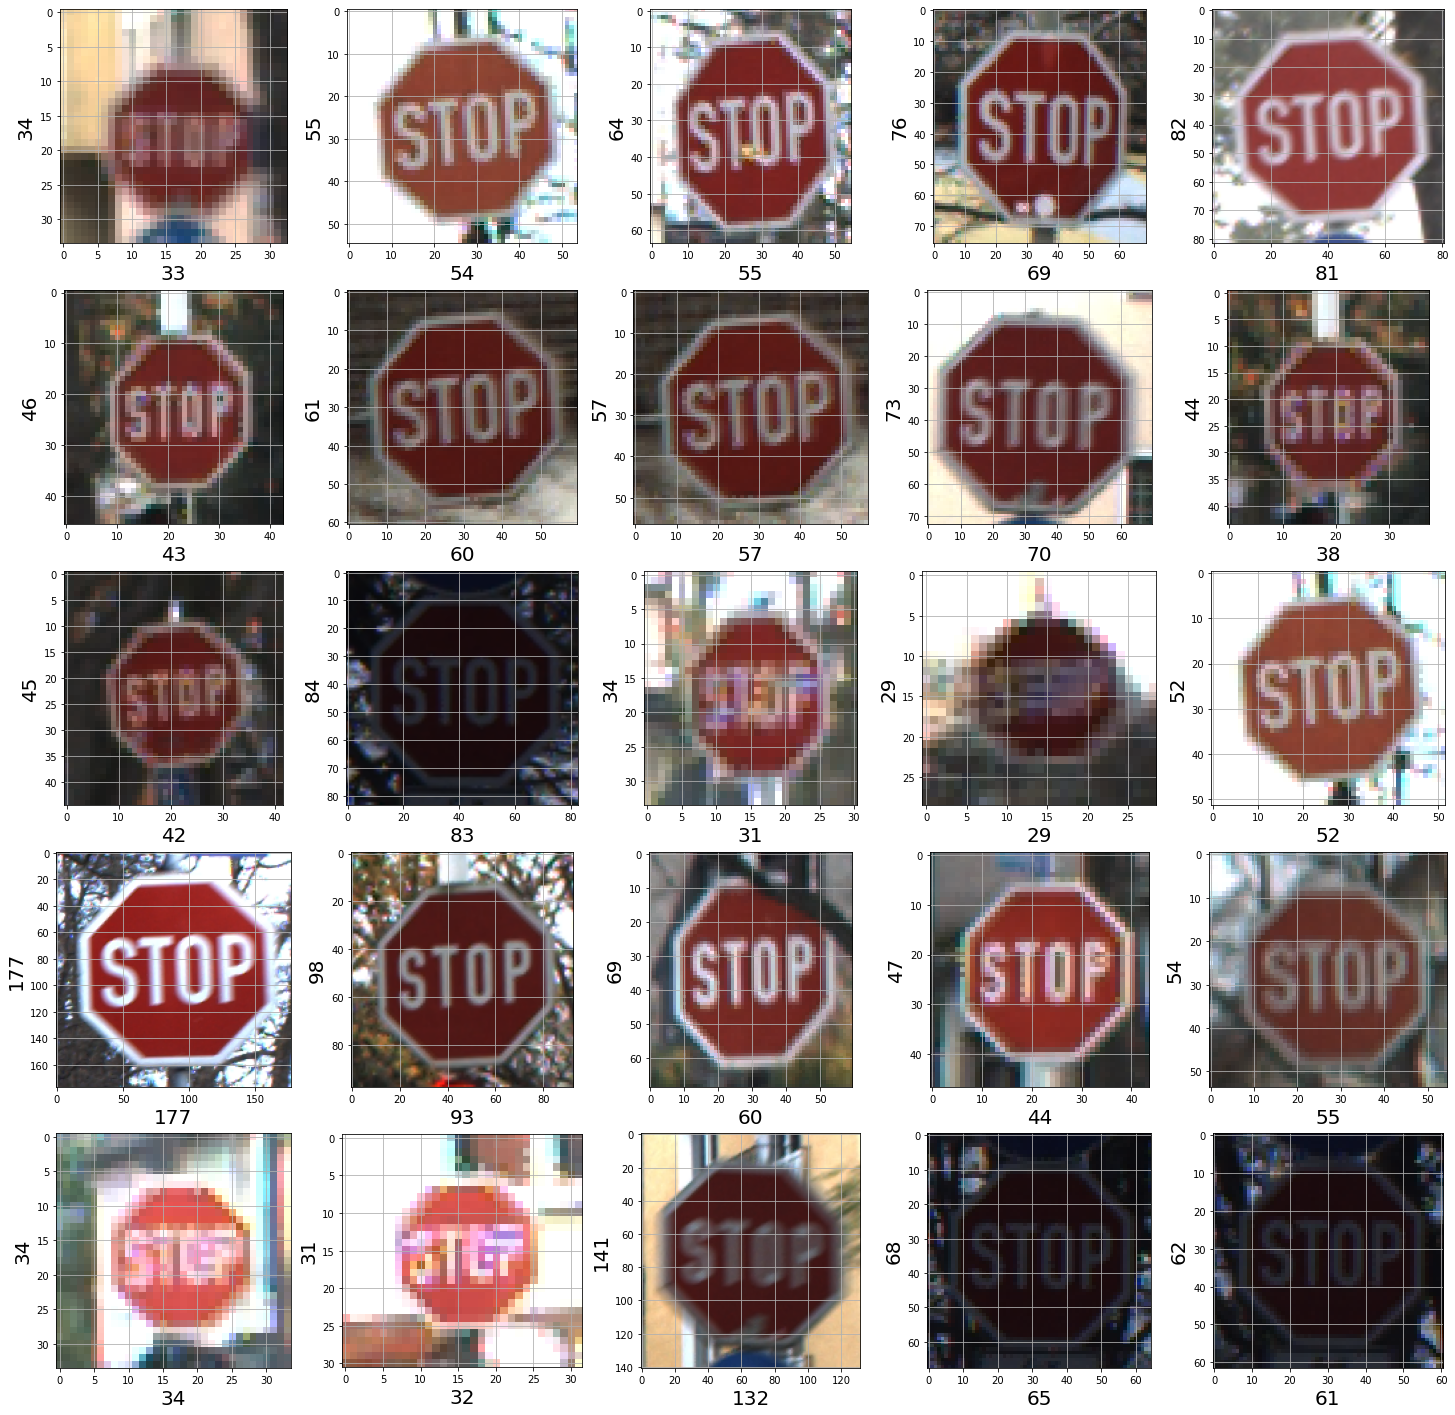

In [7]:
import random
from matplotlib.image import imread
import matplotlib.pyplot as plt

imgs = filtered_labels["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

### Detectron2 Dataset

In [8]:
from detectron2.structures import BoxMode

def get_stopsign_dicts(img_dir):
    labels = os.path.join("../input/gtsrb-german-traffic-sign/", img_dir + ".csv")
    print(labels)
    # with open(labels) as f:
    #     imgs_anns = labels.load(f)
    
    imgs_anns = pd.read_csv(labels)
    
    imgs_anns = imgs_anns[imgs_anns["ClassId"] == stop_sign_id]
    
    dataset_dicts = []
    for idx, v in imgs_anns.iterrows():
        record = {}
        
        filename = os.path.join(data_dir, v["Path"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        px = [v['Roi.X1'], v['Roi.X2']]
        py = [v['Roi.Y1'], v['Roi.Y2']]
        #poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        #poly = [p for x in poly for p in x]
        
        objs = []
        obj = {
            #"bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
            "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
            "bbox_mode": BoxMode.XYXY_ABS,
            #"segmentation": [poly],
            "category_id": 0,
        }
        objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.clear()

for d in ["Train", "Test"]:
    DatasetCatalog.register("stop_sign_" + d, lambda d=d: get_stopsign_dicts(d))
    MetadataCatalog.get("stop_sign_" + d).set(thing_classes=["stop_sign"])
balloon_metadata = MetadataCatalog.get("stop_sign_train")

../input/gtsrb-german-traffic-sign/Train.csv


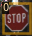

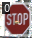

In [9]:
dataset_dicts = get_stopsign_dicts("Train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [10]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
from detectron2.evaluation import COCOEvaluator
import torch
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [11]:
from detectron2.engine import DefaultTrainer

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [12]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("stop_sign_Train",)
#cfg.DATASETS.TEST = ()
cfg.DATASETS.TEST = ("stop_sign_Test",)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 16  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.CHECKPOINT_PERIOD = 500
cfg.TEST.EVAL_PERIOD = 100

cfg.INPUT.MIN_SIZE_TRAIN = (50, 50)
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[06/23 20:11:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:21, 11.1MB/s]                           


[06/23 20:11:25 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/23 20:11:37 d2.utils.events]:  eta: 0:08:43  iter: 19  total_loss: 1.564  loss_cls: 0.7138  loss_box_reg: 0.8445  loss_rpn_cls: 0.003604  loss_rpn_loc: 0.004671  time: 0.2638  data_time: 0.0784  lr: 4.9953e-06  max_mem: 1078M
[06/23 20:11:42 d2.utils.events]:  eta: 0:08:34  iter: 39  total_loss: 1.451  loss_cls: 0.6185  loss_box_reg: 0.8409  loss_rpn_cls: 0.004287  loss_rpn_loc: 0.004511  time: 0.2565  data_time: 0.0675  lr: 9.9902e-06  max_mem: 1078M
[06/23 20:11:47 d2.utils.events]:  eta: 0:08:27  iter: 59  total_loss: 1.307  loss_cls: 0.4879  loss_box_reg: 0.8234  loss_rpn_cls: 0.003975  loss_rpn_loc: 0.004225  time: 0.2565  data_time: 0.0709  lr: 1.4985e-05  max_mem: 1078M
[06/23 20:11:52 d2.utils.events]:  eta: 0:08:16  iter: 79  total_loss: 1.222  loss_cls: 0.401  loss_box_reg: 0.8056  loss_rpn_cls: 0.004226  loss_rpn_loc: 0.003862  time: 0.2536  data_time: 0.0662  lr: 1.998e-05  max_mem: 1078M
../input/gtsrb-german-traffic-sign/Test.csv
[06/23 20:11:58 d2.data.dataset_mapper

In [13]:
import tensorflow as tf
import datetime, os
%load_ext tensorboard

In [14]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

In [15]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/23 20:31:44 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

../input/gtsrb-german-traffic-sign/Test.csv


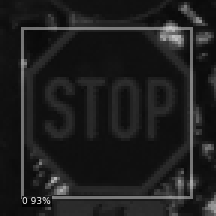

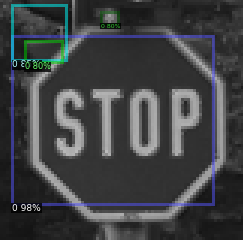

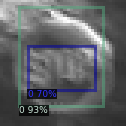

In [16]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_stopsign_dicts("Test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    #im = cv2.imread("../input/test-images/images.jpg")
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=3.0, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
    cv2.imwrite("prediction.jpg", out.get_image()[:, :, ::-1])

In [17]:
from IPython.display import display, Image
import ipywidgets as widgets
import threading

In [18]:
cap = cv2.VideoCapture(-1)
cap.set(3,640) # adjust width
cap.set(4,480) # adjust height

while True:
    success, img = cap.read()
    cv2.imshow("Webcam", img) # This will open an independent window
    if cv2.waitKey(1) & 0xFF==ord('q'): # quit when 'q' is pressed
        cap.release()
        break
        
cv2.destroyAllWindows() 
cv2.waitKey(1) # normally unnecessary, but it fixes a bug on MacOS where the window doesn't close

[ WARN:0] global /tmp/pip-req-build-jpmv6t9_/opencv/modules/videoio/src/cap_v4l.cpp (877) open VIDEOIO(V4L2): can't find camera device


error: OpenCV(4.5.4) /tmp/pip-req-build-jpmv6t9_/opencv/modules/highgui/src/window.cpp:1006: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


In [ ]:
# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


# Display function
# ================
def view(button):
    cap = cv2.VideoCapture(-1)
    display_handle=display(None, display_id=True)
    i = 0
    while True:
        _, frame = cap.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
        if stopButton.value==True:
            cap.release()
            display_handle.update(None)

            
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()